## Using SHAP for interpretability

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dotenv import load_dotenv
import os
import numpy as np


from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb
from ngboost import NGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor

import pickle
import shap
shap.initjs()

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,HipsSumVariancebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,0,81.3479,2,20.0,NaN,158.27,0.63,218.30,28.37,714.92,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,546.93,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,689.44,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,622.01,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,1,73.9726,2,24.0,0.11,233.02,0.48,229.88,39.46,686.51,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [4]:
imputer_nonLin = IterativeImputer(
    estimator=DecisionTreeRegressor(),
    random_state=42,
)

imputer_nonLin.fit(X_train)
X_train_missForest = imputer_nonLin.transform(X_train)
X_test_missForest = imputer_nonLin.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [5]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((366, 22), (158, 22))

In [8]:
# Store selected feature names before transformation
sel = ['Ageatscreening', 'MMSE0m', 'HipsContrastbaseline',
       'HipsEntropybaseline', 'ERCsContrastbaseline', 'ERCsCorelationbaseline',
       'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline']

In [9]:
# Store selected feature names before transformation
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Ageatscreening',
 'MMSE0m',
 'HipsContrastbaseline',
 'HipsEntropybaseline',
 'ERCsContrastbaseline',
 'ERCsCorelationbaseline',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'HipposcampusVolumebaseline']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((366, 9), (158, 9))

In [11]:
with open("rf_model.pkl", "rb") as file:
    loaded_model_rf = pickle.load(file)
print(f"{loaded_model_rf} model loaded successfully!\n")

with open("xgboost_model.pkl", "rb") as file:
    loaded_model_xgb = pickle.load(file)
print(f"{loaded_model_xgb} model loaded successfully!\n")


with open("ngboost_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)
print(f"{loaded_model_ngb} model loaded successfully!")

with open("logit_model.pkl", "rb") as file:
    loaded_model_logit = pickle.load(file)
print(f"{loaded_model_logit} model loaded successfully!")

RandomForestClassifier(class_weight='balanced_subsample', max_depth=4,
                       max_features='log2',
                       min_samples_leaf=0.007814896131893399,
                       min_samples_split=0.11995960750316327, n_estimators=332,
                       random_state=42) model loaded successfully!

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7827543462946842, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.8474757275525653,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.10617100370417812,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=N

In [12]:
# Compute SHAP values for Random Forest
explainer_rf = shap.TreeExplainer(loaded_model_rf)
shap_values_rf = explainer_rf.shap_values(X_test_t)

# Compute SHAP values for XGBoost
explainer_xgb = shap.TreeExplainer(loaded_model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_t)

# Compute SHAP values for NGBoost
explainer_ngb = shap.Explainer(loaded_model_ngb.predict_proba, X_test_t)
shap_values_ngb = explainer_ngb(X_test_t)

# Compute SHAP values for Logistic Regression
explainer_logit = shap.LinearExplainer(loaded_model_logit, X_test_t)
shap_values_logit = explainer_logit.shap_values(X_test_t)

ExactExplainer explainer: 159it [21:53,  8.31s/it]                         


In [13]:
print(shap_values_rf.shape)
print(shap_values_xgb.shape)
print(shap_values_ngb.shape)
print(shap_values_logit.shape)

(158, 9, 3)
(158, 9, 3)
(158, 9, 3)
(158, 9, 3)


## Global interpretability

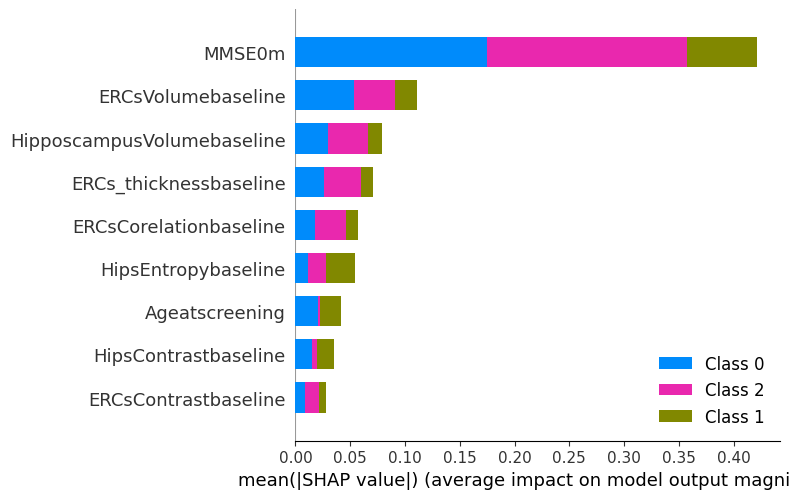

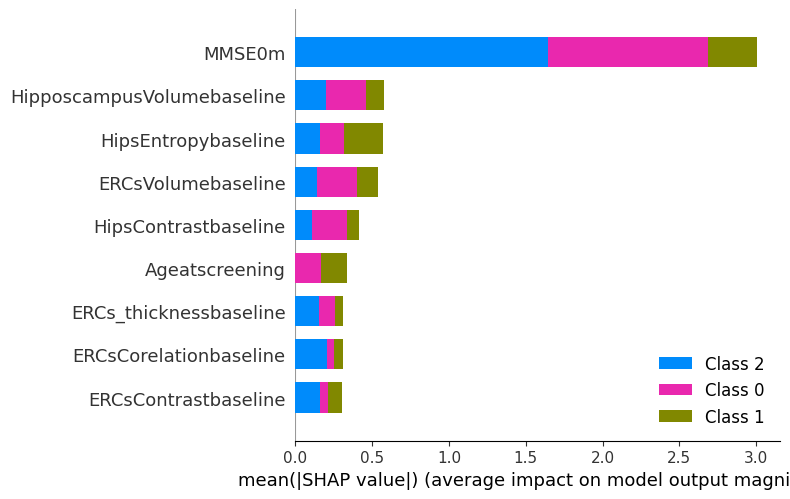

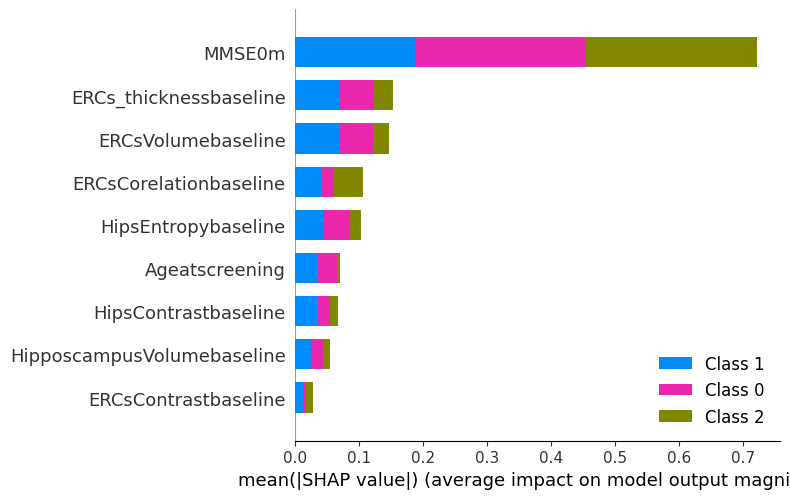

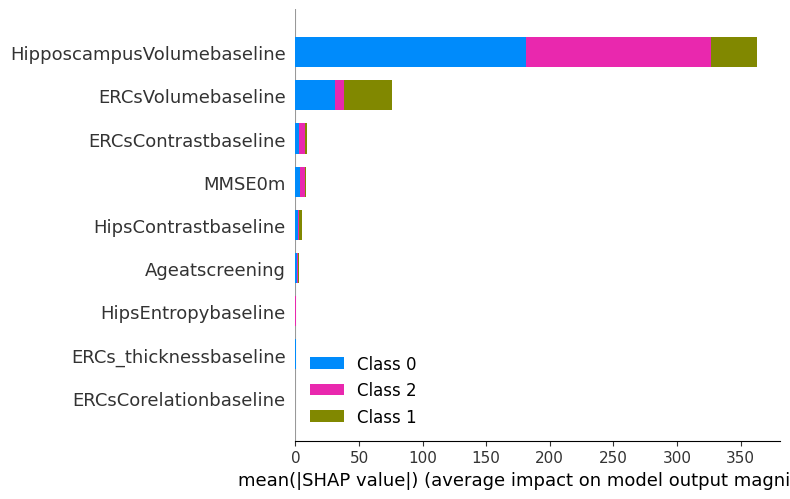

In [14]:
# Beeswarm plots
shap.summary_plot(shap_values_rf, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_ngb.values, X_test_t, feature_names=X_test_t.columns, plot_type="bar")
shap.summary_plot(shap_values_logit, X_test_t, feature_names=X_test_t.columns, plot_type="bar")

## Local interpretability

In [15]:
## SHAP plot for loc trees
explainer_rf = shap.TreeExplainer(loaded_model_rf) 
shap_values_rf = explainer_rf.shap_values(X_test_t)

print(shap_values_rf.shape)
print(explainer_rf.expected_value)

(158, 9, 3)
[0.33333333 0.33333333 0.33333333]


In [16]:
# Force plot for the first instance
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0, :, 1], X_test_t.iloc[0, :], feature_names=X_test_t.columns)

SHAP Beeswarm Plot for Class 0


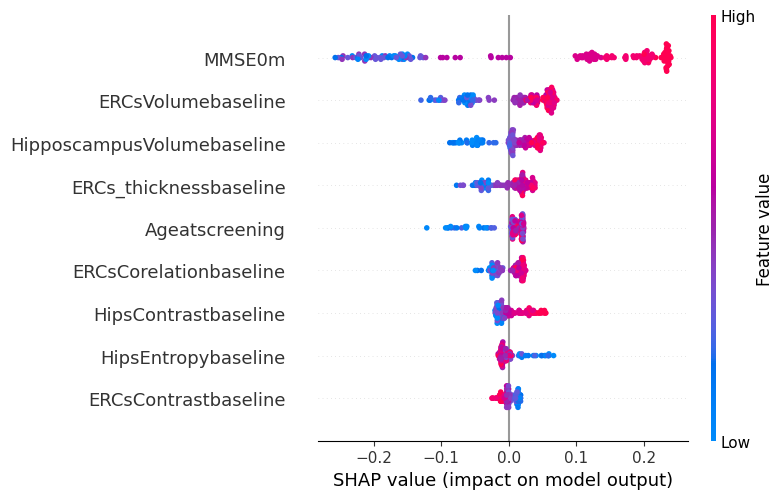

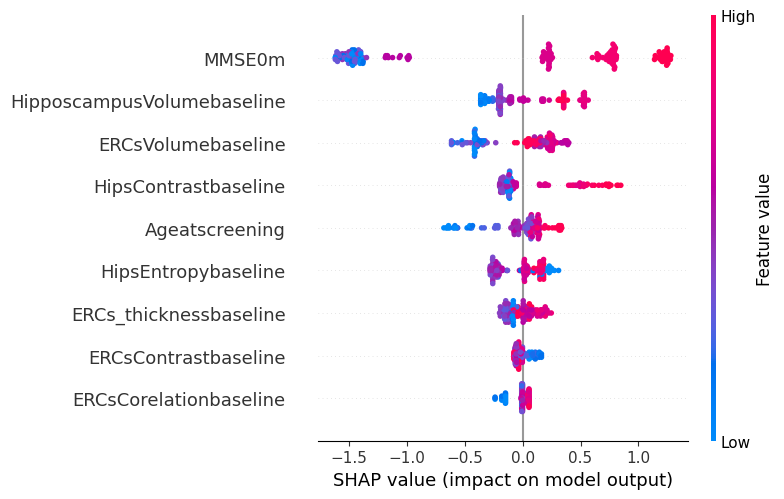

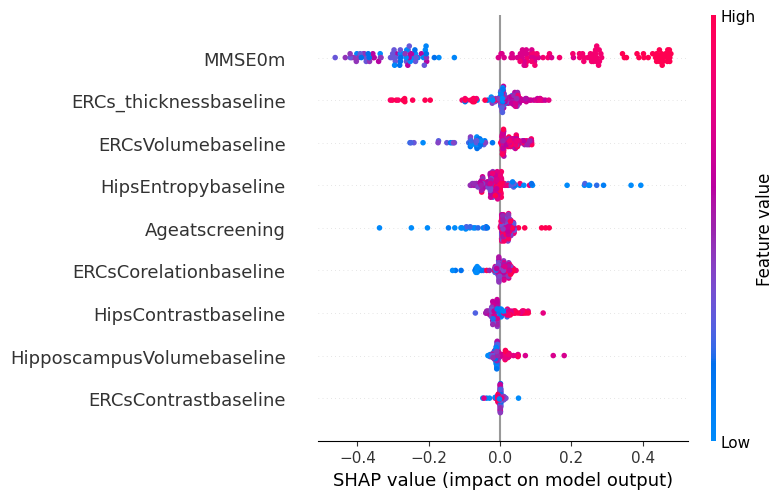

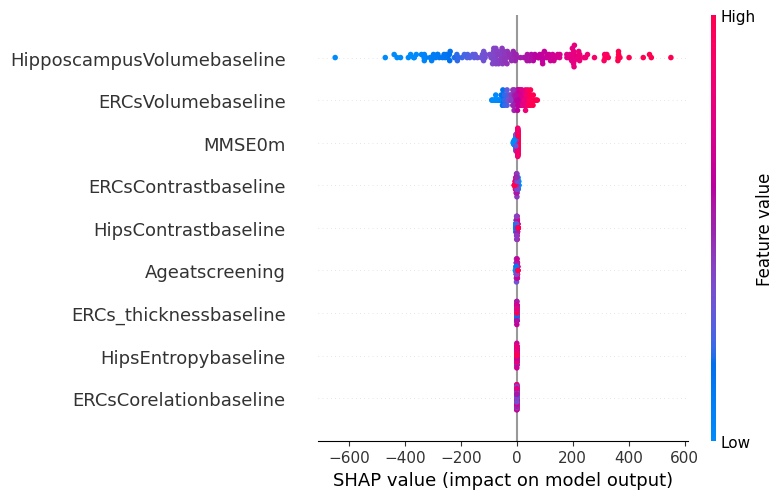

SHAP Beeswarm Plot for Class 1


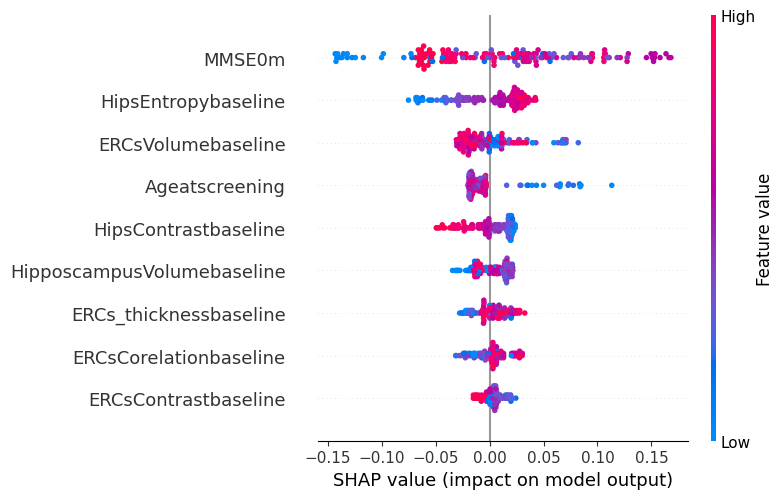

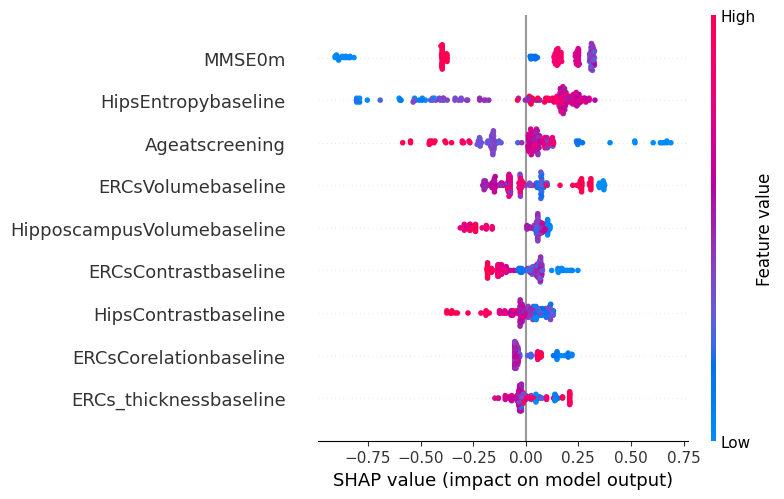

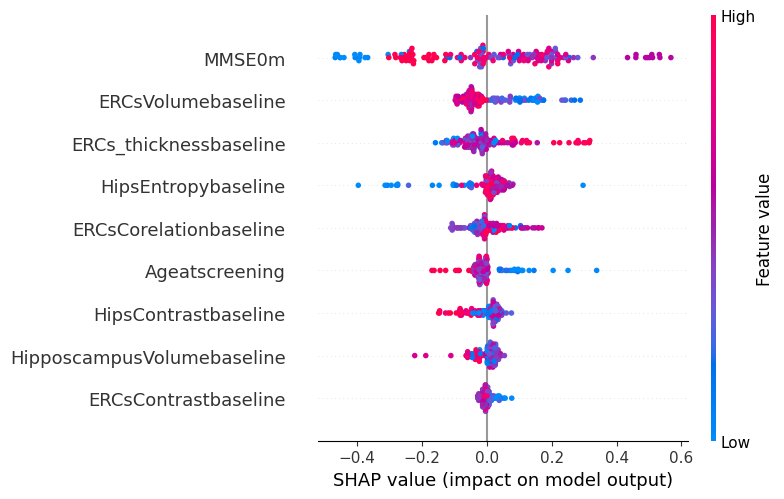

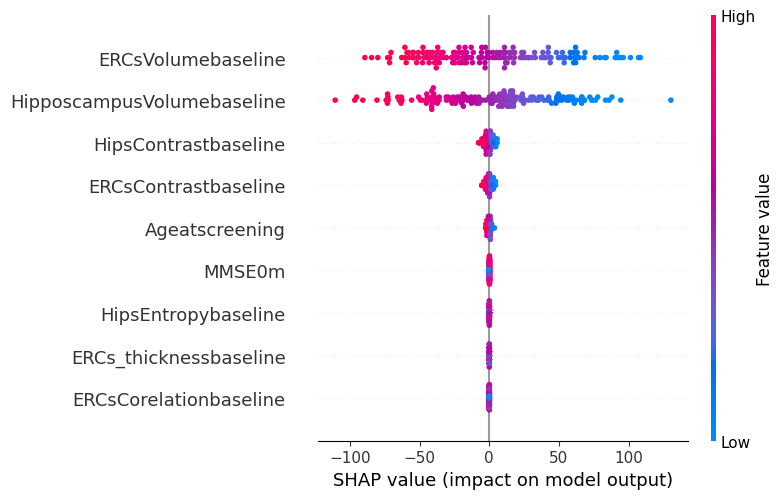

SHAP Beeswarm Plot for Class 2


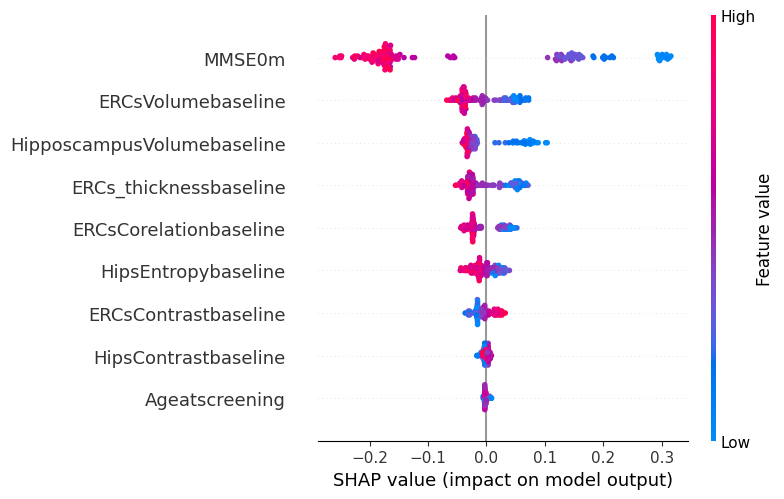

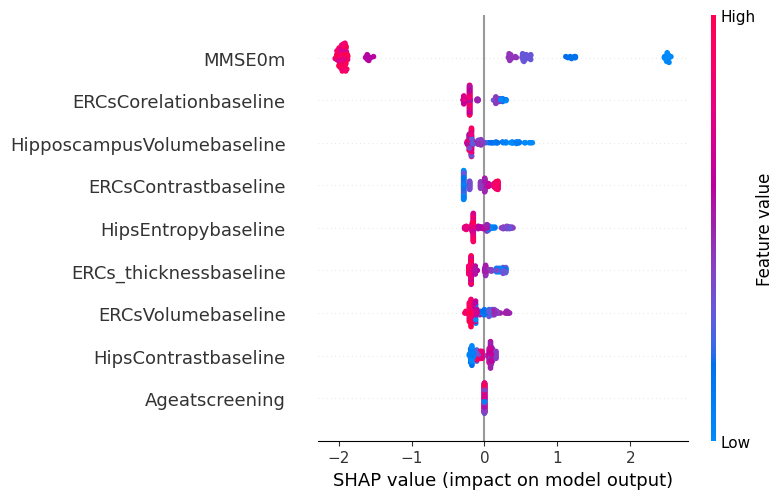

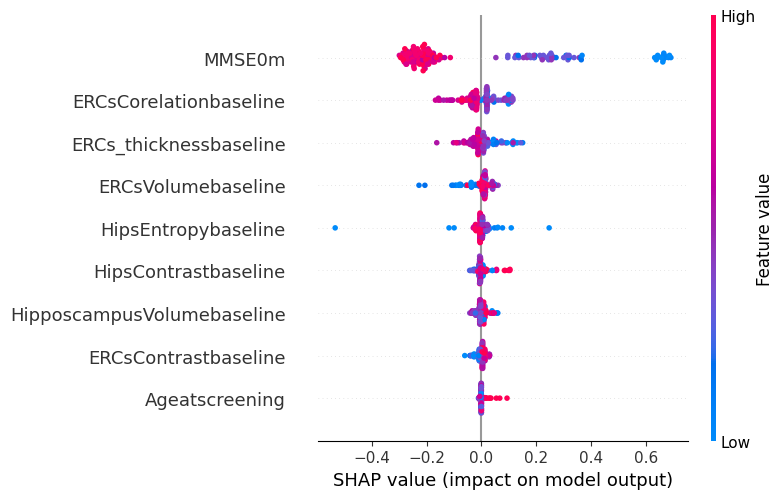

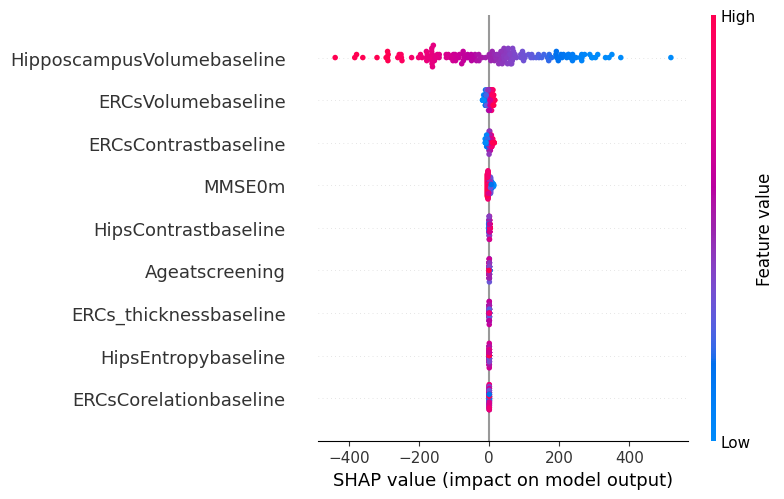

In [17]:
# Plot SHAP beeswarm for each class
for class_idx in range(shap_values_rf.shape[2]):  # Loop over each class
    print(f"SHAP Beeswarm Plot for Class {class_idx}")

    # Random Forest
    shap.summary_plot(shap_values_rf[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)

    # XGBoost
    shap.summary_plot(shap_values_xgb[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)

    # NGBoost
    shap.summary_plot(shap_values_ngb.values[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)
    
    # Logistic
    shap.summary_plot(shap_values_logit[:, :, class_idx], X_test_t, feature_names=X_test_t.columns)


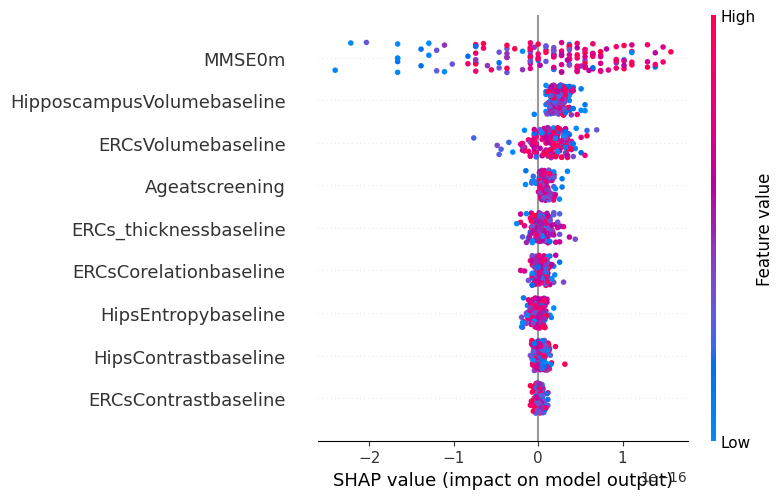

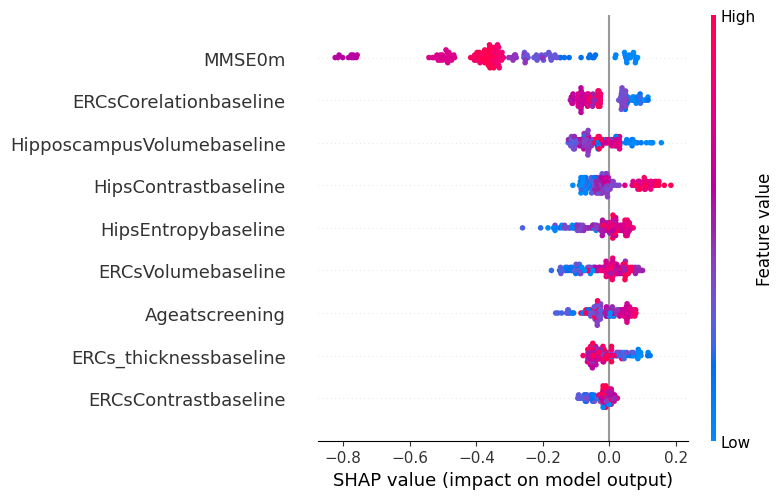

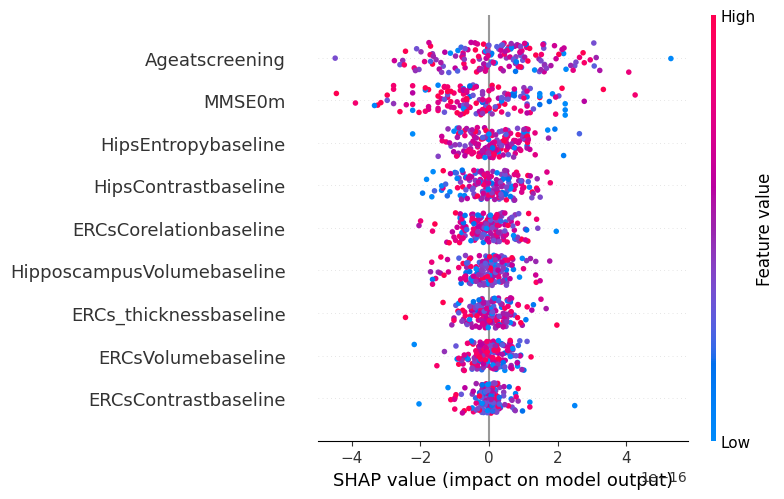

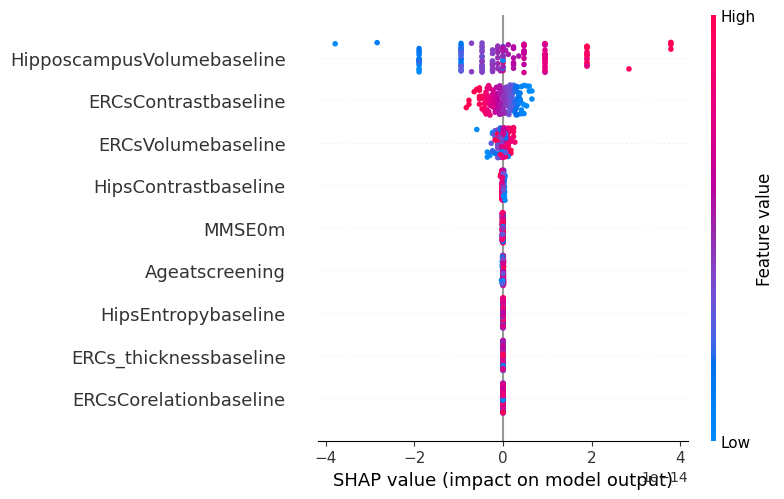

In [18]:
shap_values_rf_mean = shap_values_rf.mean(axis=2)  # Average over classes
shap_values_xgb_mean = shap_values_xgb.mean(axis=2)
shap_values_ngb_mean = shap_values_ngb.values.mean(axis=2)
shap_values_logit_mean = shap_values_logit.mean(axis=2)
# Plot the aggregated beeswarm plots
shap.summary_plot(shap_values_rf_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_xgb_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_ngb_mean, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_logit_mean, X_test_t, feature_names=X_test_t.columns)


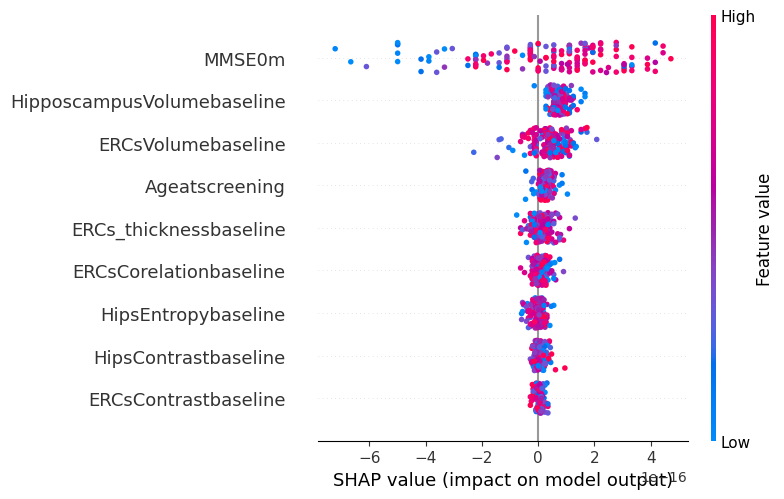

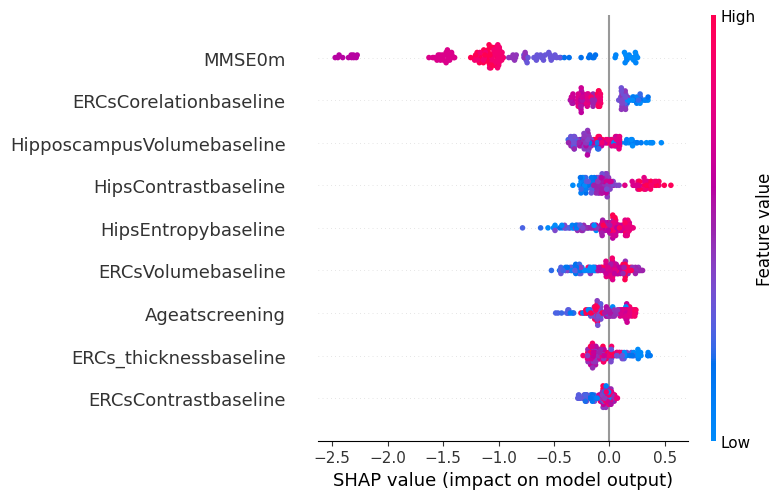

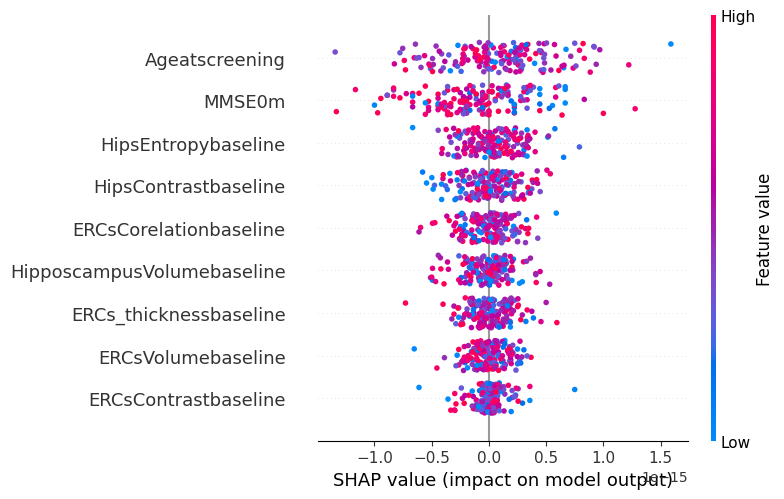

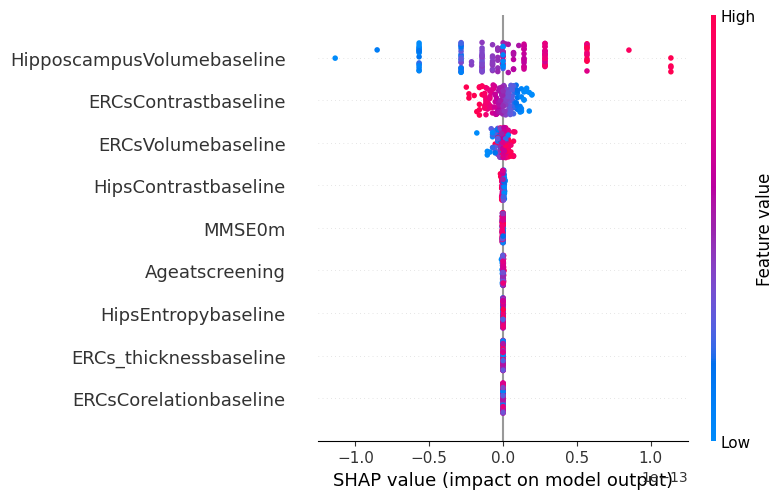

In [19]:
shap_values_rf_sum = shap_values_rf.sum(axis=2)  # Sum over classes
shap_values_xgb_sum = shap_values_xgb.sum(axis=2)
shap_values_ngb_sum = shap_values_ngb.values.sum(axis=2)
shap_values_logit_sum = shap_values_logit.sum(axis=2)

# Plot the aggregated beeswarm plots
shap.summary_plot(shap_values_rf_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_xgb_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_ngb_sum, X_test_t, feature_names=X_test_t.columns)
shap.summary_plot(shap_values_logit_sum, X_test_t, feature_names=X_test_t.columns)